https://gymnasium.farama.org/environments/box2d/lunar_lander/

### Ustawienie hardware

In [1]:
import torch

OPTIMIZE_WITH_HARDWARE = True

device = torch.device('cpu')
if OPTIMIZE_WITH_HARDWARE:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f'Selected device: MPS')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Selected device: GPU with CUDA support')
        print(f'CUDA device name: {torch.cuda.get_device_name()}')
        print(f'CUDA device count: {torch.cuda.device_count()}')
        print(f'CUDA device index: {torch.cuda.current_device()}')
else:
    print(f'Selected device: CPU')
    

Selected device: GPU with CUDA support
CUDA device name: Quadro M1200
CUDA device count: 1
CUDA device index: 0


# Ogólne przedstawienie problemu

In [2]:
import gymnasium as gym
env = gym.make("LunarLander-v3")

In [3]:
import warnings
warnings.filterwarnings('ignore')

env.reset()

terminated = False
truncated = False

while not (terminated or truncated):
    action = 1
    obs, reward, terminated, truncated, info  = env.step(action)
    env.render()
    
env.close()

## Co zwraca środowisko?

- pozycja pozioma lądownika (x);
- pozycja pionowa lądownika (y)
- prędkość pozioma lądownika
- prędkość pionowa lądownika
- kąt nachylenia lądownika
- prędkość kątowa lądownika
- czy noga nr 1 (lewa) lądownika dotyka podłoża
- czy noga nr 2 (prawa) lądownika dotyka podłoża

## Ile akcji może wykonać agent?

In [4]:
print(f'Ilość możliwych akcji: {env.action_space.n}')

Ilość możliwych akcji: 4


1. Brak działania
2. Uruchomiony główny silnik
3. Uruchomiony lewy silnik
4. Uruchomiony peawy silnik

## Struktura sieci głębokiej

- Otrzymujemy stan w postaci wektora ośmiu wyżej wymienionych parametrów. Definiujemy 3 liniowe warstwy, tzn. przetwrzające dane liniowo, realizujące sume ważoną.
- Pierwsza warstwa przyjmuje stan w którym znajduje się łazik (state_size), rozszerza na 128 parametrów.
- Druga warstwa przyjmuje 128 parametrów i na wyjściu ma 128 parametrów.
- Trzecia warstwa która będzie podawać wartość Q dla każdej możliwej do podjęcia akcji przyjmuje 128 parametrów i zwraca 4 wyjścia (action_size)

In [5]:
from torch import nn # importujemy moduł nn z biblioteki torch
import torch.nn.functional as F
class DQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)
        
    def forward(self, state):
        x = F.leaky_relu(self.fc1(state), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.fc3(x)
        return x

## Definicja agenta sieci DQN

In [6]:
from collections import deque # impor kolejki deque z modułu collections
import numpy as np
import random

# Hyperparametry sieci neuronowej
BATCH_SIZE = 16
LEARNING_RATE = 0.001

class DQNAgent(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNAgent, self).__init__()
        self.input_size = input_size # ilość wejść, ilo informacji dot. stanu środowiska
        self.output_size = output_size # ilość wyjść, ilość możliwych akcji
        self.discount_factor = 0.99 # współczynnik dyskontujący
        self.epsilon_greedy = 1.0 # początkowya wartość losowego wyboru akcji
        self.epsilon_min = 0.1 # minimalna wartość losowego wyboru akcji ''' Zmiana z 0.01 na 0.1 '''
        self.epsilon_greedy_decay = 0.995 # współczynnik zmniejszający wartość losowego wyboru akcji (co iteracje o 5%)
        self.train_start = 500 # ilość próbek w pamięci agenta, po której rozpoczynamy uczenie
        self.memory = deque(maxlen=1000) # pamięć agenta

        self.model = DQNetwork(input_size, output_size).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_function = nn.MSELoss()

    def memorize(self, state, action, reward, next_state, done): 
        '''metoda dodająca informacje do pamięci agenta'''
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        '''wybiera akcję na podstawie stanu, jeśli model zwróci wartość większą niż epsilon_greedy,
        to wybieramy akcję o największej wartości, w przeciwnym wypadku wybieramy losową akcję. unsqueeze(0) dodaje dodatkowy wymiar [BATCH_SIZE, input_size].
        Pytorch operuje na tensorach, który w pierwszym wymiarze zawiera informacje i ilość paczek, następnie dane treningowe.
        "unsqueeze(0)" dodaje dodatkowy wymiar, który jest wymagany przez model, mimo że jest jedna paczka w funkcji.'''
        
        if np.random.rand() <= self.epsilon_greedy:
            return random.randrange(self.output_size)
        
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values_predicted = self.model(state)
            return torch.argmax(q_values_predicted).item()

    def replay(self):
        '''metoda ucząca model na podstawie próbek z pamięci agenta'''
        total_mse_loss = 0
        if len(self.memory) < self.train_start:
            return
        
        data_batch = random.sample(self.memory, BATCH_SIZE) # losujemy próbki z pamięci agenta

        for state, action, reward, next_state, done in data_batch:
            state = torch.FloatTensor(state).to(device)
            next_state = torch.FloatTensor(next_state).to(device) #następny stan który zwróci środowisko dla danego doświdczenia
            reward = torch.FloatTensor([reward]).to(device)
            discount_reward = reward
            if not done:
                discount_reward += torch.max(self.model(next_state)) * self.discount_factor # obliczamy zniżone nagrody
            
            dqnprediction = self.model(state)
            true_reward = dqnprediction.clone() # klonujemy wartość predykcji
            true_reward[action] = discount_reward # nadpisujemy wartość nagrody dla danej akcji

            loss = self.loss_function(dqnprediction, true_reward)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() # aktualizujemy wagi modelu
            total_mse_loss += loss.item()

        if self.epsilon_greedy > self.epsilon_min:
            self.epsilon_greedy *= self.epsilon_greedy_decay # zmniejszamy wartość losowego wyboru akcji
        
        return total_mse_loss/BATCH_SIZE # zwracamy średni błąd kwadratowy


### Zapis daanych treningowych

In [7]:
def save(model, optimizer, episode, file_name='model.pth'):
    checkpoint = {
        'episode': episode,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_name)



def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])  # Załaduj wagi modelu
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Załaduj stan optymalizatora
    episode = checkpoint['episode']  # Załaduj numer epoki
    return episode

## Definicja pętli treningowej modelu

In [8]:
import math

env = gym.make("LunarLander-v3", render_mode='human') # inicjalizacja środowiska
input_size = env.observation_space.shape[0] # rozmir informacji o stanie zwracanym przez środowisko
output_size = env.action_space.n # ilość możliwych akcji
agent = DQNAgent(input_size, output_size) # inicjalizacja agenta

# Śledzenie postępu
rewards_history = []
epsilon_history = []
loss_history = []

episodes = 1000
for episode in range(episodes): # pętla ucząca agenta
    state, _ = env.reset()
    done = False
    total_reward = 0
    step_counter = 0
    total_mse_loss = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)

        agent.memorize(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state
        step_counter += 1

        mse_loss = agent.replay()
        if mse_loss is not None:
            total_mse_loss += mse_loss
        if done:
            AVG_MSE_LOSS = total_mse_loss/step_counter if step_counter > 0 else 0
            print(f"""Episode: {episode+1}/{episodes}, Reward: {total_reward:.2f}
                  Epsilon: {agent.epsilon_greedy:.3f}, MSE: {total_mse_loss:.3f} 
                  Loss: {math.sqrt(total_mse_loss):.2f}""")
            rewards_history.append(total_reward) # zapisujemy dane o postępie
            epsilon_history.append(agent.epsilon_greedy)
            loss_history.append(math.sqrt(AVG_MSE_LOSS))
            break
    
    # Zapisujemy nasz trenowany model co 10 epizod
    # Zamiast "filename=f" użyj "file_name=f"
    if episode % 10 == 0:
        save(agent.model, agent.optimizer, episode, file_name=f"model_checkpoint_{episode}.pth")


env.close()


Episode: 1/1000, Reward: -192.28
                  Epsilon: 1.000, MSE: 0.000 
                  Loss: 0.00
Episode: 2/1000, Reward: -278.02
                  Epsilon: 1.000, MSE: 0.000 
                  Loss: 0.00
Episode: 3/1000, Reward: -192.40
                  Epsilon: 1.000, MSE: 0.000 
                  Loss: 0.00
Episode: 4/1000, Reward: -173.22
                  Epsilon: 1.000, MSE: 0.000 
                  Loss: 0.00
Episode: 5/1000, Reward: -197.43
                  Epsilon: 1.000, MSE: 0.000 
                  Loss: 0.00
Episode: 6/1000, Reward: -108.70
                  Epsilon: 0.673, MSE: 2248.595 
                  Loss: 47.42
Episode: 7/1000, Reward: -312.55
                  Epsilon: 0.455, MSE: 889.463 
                  Loss: 29.82
Episode: 8/1000, Reward: -98.47
                  Epsilon: 0.203, MSE: 793.623 
                  Loss: 28.17
Episode: 9/1000, Reward: -260.40
                  Epsilon: 0.075, MSE: 617.658 
                  Loss: 24.85
Episode: 10/1000

## Wykresy

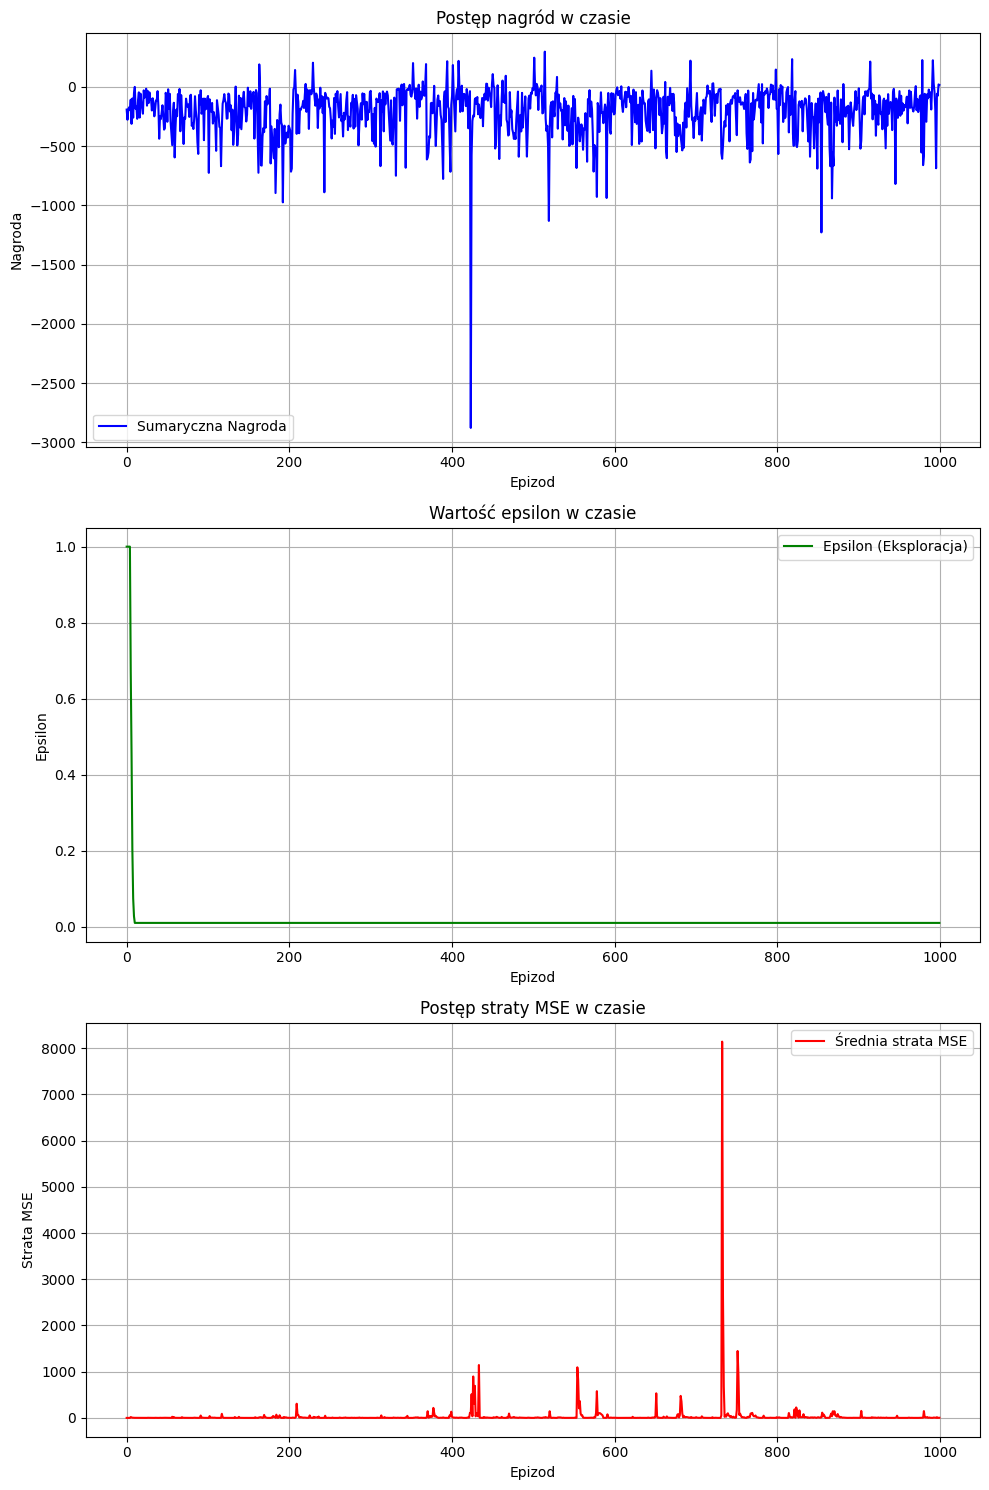

In [9]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
# Wykres nagród
ax1.plot(rewards_history, label='Sumaryczna Nagroda', color='blue')
ax1.set_title("Postęp nagród w czasie")
ax1.set_xlabel("Epizod")
ax1.set_ylabel("Nagroda")
ax1.legend()
ax1.grid()

# Wykres epsilon
ax2.plot(epsilon_history, label='Epsilon (Eksploracja)', color='green')
ax2.set_title("Wartość epsilon w czasie")
ax2.set_xlabel("Epizod")
ax2.set_ylabel("Epsilon")
ax2.legend()
ax2.grid()

# Wykres straty MSE
ax3.plot(loss_history, label='Średnia strata MSE', color='red')
ax3.set_title("Postęp straty MSE w czasie")
ax3.set_xlabel("Epizod")
ax3.set_ylabel("Strata MSE")
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()